### Convert dataset to numeric representation

In [168]:
# %%capture thiscell
# #hide output of this cell
# %run ./feature_extraction.ipynb

In [169]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(MFCC_df.MFCC.tolist())
y = np.array(MFCC_df.class_label.tolist())
%store X
%store y
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
# yy is one-hot encoding of label
%store yy
print(X.shape)
print(yy.shape)

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'yy' (ndarray)
(1618, 40)
(1618, 29)


### Stratify dataset
Stratifying dataset can make each class distributed evenly

In [170]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Apply different models

- Multilayer Perceptron (MLP) Neural Network

The model has three dense layer:
1. Input layer has 40 nodes because our dataset shape of each instance is 1x40
2. One hidden layer including 256 nodes
3. Output layer including 29 nodes because we have 29 categories

- Model construction

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2
# Construct model
model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

- Model compiling

In [172]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()
# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               10496     
                                                                 
 activation_21 (Activation)  (None, 256)               0         
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 activation_22 (Activation)  (None, 256)               0         
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 29)               

- Model training

In [173]:
%%capture thiscell
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs = 100
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5',
verbose=1, save_best_only=True)
start = datetime.now()
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test))
duration = datetime.now() - start

In [174]:
print("Training completed in time: ", duration)
score = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy: ", score[1])

Training completed in time:  0:00:08.283739
Test accuracy:  0.8672839403152466


In [175]:
%%capture thiscell
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

y_cat={}
y_num=[]
new_y=list(set(y))
enu_y=list(enumerate(new_y))
for count, item in enu_y:
    y_cat[item]=count
for y_item in y:
    y_num.append(y_cat[y_item])

n_classes = len(set(y))
Y = label_binarize(y_num, classes=[*range(n_classes)])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    random_state = 42)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test,y_test))
y_score = model.predict(X_test)


### PR curve

Text(0.5, 1.0, 'precision vs. recall curve')

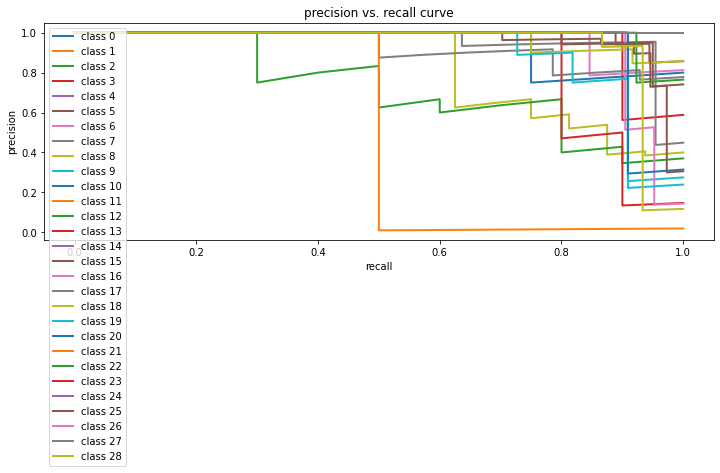

In [176]:
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

#plt.rcParams["figure.figsize"] = (12,4)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")

### ROC curve

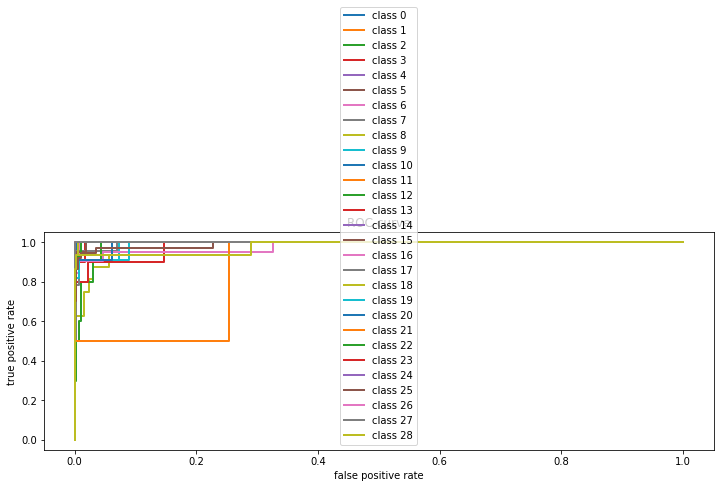

In [177]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

#plt.rcParams["figure.figsize"] = (12,4)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### KNN with default parameters

max accuracy:  0.7822248898904587 when k is  1


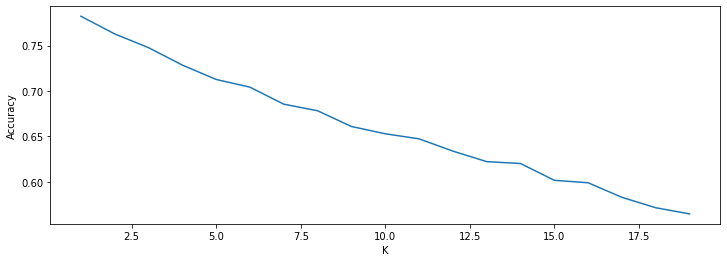

In [194]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

cv_scores = []
for n in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=n)   
    scores = cross_val_score(knn,
                             X,
                             y_num,
                             cv=10,
                             scoring='f1_weighted')  
    cv_scores.append(scores.mean())
plt.plot(range(1,20),cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
print("max accuracy: ", max(cv_scores),"when k is ", cv_scores.index(max(cv_scores))+1)

### Grid search for KNN

In [195]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
n_neighbors_list = range(1,20)
metric_list=['euclidean','manhattan','chebyshev','hamming','canberra','braycurtis']
weights_list = ['uniform', 'distance']
parameters={'n_neighbors':n_neighbors_list,'metric':metric_list, 'weights':weights_list}
# create GridSearchCV
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1, verbose=3,
                   cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='f1_weighted')
#clf.fit(np.array(MFCC_df.MFCC.tolist()),le.transform(np.array(MFCC_df.class_label.tolist())))
#clf.fit(x_train_random,y_train_random)
clf.fit(X,y_num)

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'hamming', 'canberra', 'braycurtis'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted', verbose=3)

In [196]:
# print the table of scores and parameters
result=pd.DataFrame.from_dict(clf.cv_results_)
result=result.loc[:,["param_metric","param_n_neighbors","param_weights","mean_test_score","std_test_score","rank_test_score"]]
result.sort_values("rank_test_score",inplace=True)
result.set_index(["rank_test_score"])[:20]

,param_metric,param_n_neighbors,param_weights,mean_test_score,std_test_score
rank_test_score,,,,,
1,braycurtis,1,uniform,0.924305,0.010509
1,braycurtis,1,distance,0.924305,0.010509
1,braycurtis,2,distance,0.924305,0.010509
4,manhattan,1,uniform,0.920833,0.011275
4,manhattan,1,distance,0.920833,0.011275
4,manhattan,2,distance,0.920833,0.011275
7,manhattan,3,distance,0.913228,0.015798
8,braycurtis,3,distance,0.912609,0.009089
9,braycurtis,2,uniform,0.909700,0.009834


### Random forest

In [218]:
%%capture thiscell
from sklearn.ensemble import RandomForestClassifier
for i in range(len(y_num_temp)):
    if y_num_temp[i]==2:
        y_num_temp[i]=0
    if y_num_temp[i]==9:
        y_num_temp[i]=1
parameters={'n_estimators':range(50,300,50),
            'criterion':['gini', 'entropy'],
            'min_samples_split':range(1,10,2)}
#parameters={'n_estimators':range(50,150,10)}
# create GridSearchCV
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, verbose=3,
                   cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_weighted')
clf.fit(X,y_num)

In [219]:
# print the table of scores and parameters
# print the table of scores and parameters
result=pd.DataFrame.from_dict(clf.cv_results_)
#result=result.loc[:,["param_n_estimators","param_criterion","param_min_samples_split","mean_test_score","std_test_score","rank_test_score"]]
result=result.loc[:,["param_n_estimators","mean_test_score","std_test_score","rank_test_score"]]
result.sort_values("rank_test_score",inplace=True)
result.set_index(["rank_test_score"])[:10]


,param_n_estimators,mean_test_score,std_test_score
rank_test_score,,,
1,200,0.886363,0.009483
2,250,0.884798,0.014245
3,150,0.880770,0.010468
4,250,0.879889,0.017959
5,200,0.879446,0.020814
6,200,0.877965,0.008964
7,250,0.877947,0.014137
8,250,0.876916,0.019434
9,100,0.875812,0.020102
